### Initial Setup, Get Dataset Directories

In [7]:
import os
import numpy as np
from PIL import Image

# Base directory where you extracted the AI4Mars data
base_dir = '/home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data' 
# Directories for the training images and their corresponding masks
mer_dir = os.path.join(base_dir, 'mer/')
msl_dir = os.path.join(base_dir, 'msl/')

# Directories for the testing images and their corresponding masks
mer_train_img_dir = os.path.join(mer_dir, 'images/train')
mer_test_img_dir = os.path.join(mer_dir, 'images/test')
mer_train_mask_dir = os.path.join(mer_dir, 'labels/train/merged-unmasked')
mer_test_mask_dir = os.path.join(mer_dir, 'labels/test/masked-gold-min1-100agree')

# msl_train_img_dir = os.path.join(msl_dir, 'images/train')
# msl_test_img_dir = os.path.join(msl_dir, 'images/test')
# msl_train_mask_dir = os.path.join(msl_dir, 'labels/train')
# msl_test_mask_dir = os.path.join(msl_dir, 'labels/test')

print(f"MER Training Images Directory: {mer_train_img_dir}")
print(f"MER Testing Images Directory {mer_test_img_dir}")
print(f"MER Training Mask Directory {mer_train_mask_dir}")
print(f"MER Testing Mask Directory {mer_test_mask_dir }")

# print(f"MSL Training Images Directory: {msl_train_img_dir}")
# print(f"MSL Testing Images Directory {msl_test_img_dir}")
# print(f"MSL Training Mask Directory {msl_train_mask_dir}")
# print(f"MSL Testing Mask Directory {msl_test_mask_dir }")

MER Training Images Directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
MER Testing Images Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
MER Training Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
MER Testing Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree


### Functions

In [ ]:
import os
import re
from typing import List, Tuple

# Allowed extensions for the AI4Mars dataset images and masks
ALLOWED_EXTENSIONS = ('.jpg', '.png', '.jpeg')

def get_base_name(filename: str) -> str:
    # 1. Remove file extension
    base = os.path.splitext(filename)[0]
    
    # Suffix Removal Pattern (case-insensitive, applied only at the end)
    # Pattern explanation:
    #   (_\d{5}_T\d_merged) : Targets the Test Mask structure (e.g., _16165_T0_merged)
    #    | _merged\d* : Targets the Train Mask structure (e.g., _merged0, _merged1)
    #    | _mer              : Handles general _mer cases
    #    The entire match must be at the end of the string ($)
    suffix_pattern = r'(_\d{5}_T\d_merged|_merged\d*|_mer)$'
    base = re.sub(suffix_pattern, '', base, flags=re.IGNORECASE)
    
    return base

def get_matched_pairs(img_dir: str, mask_dir: str) -> List[Tuple[str, str]]:

    print(f"\n[Matching] Checking image directory: {img_dir}")
    print(f"[Matching] Checking mask directory: {mask_dir}")
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        print("Error: One or both directories do not exist.")
        return []

    image_files = sorted([f for f in os.listdir(img_dir) 
                          if f.lower().endswith(ALLOWED_EXTENSIONS)])
    mask_candidates = [f for f in os.listdir(mask_dir) 
                       if f.lower().endswith(ALLOWED_EXTENSIONS)]
    
    print(f"[Matching] Found {len(image_files)} potential images.")
    print(f"[Matching] Found {len(mask_candidates)} mask candidates.")

    # Build the Mask Lookup Map (Base Name -> Mask Full Path)
    mask_map = {}
    for mask_file in mask_candidates:
        base_name = get_base_name(mask_file)
        mask_map[base_name] = os.path.join(mask_dir, mask_file)
            
    # Find Matches
    matched_pairs = []
    unmatched_images = []
    
    for img_filename in image_files:
        img_base_name = get_base_name(img_filename)
        
        if img_base_name in mask_map:
            img_path = os.path.join(img_dir, img_filename)
            mask_path = mask_map[img_base_name]
            matched_pairs.append((img_path, mask_path))
        else:
            unmatched_images.append(img_filename)

    print(f"[Matching] Successfully identified {len(matched_pairs)} image/mask pairs.")
    if unmatched_images:
        print(f"[Matching] Warning: {len(unmatched_images)} images had NO matching mask.")
        # Provide a specific example of the failure for debugging future issues
        if unmatched_images:
            ex_img_name = unmatched_images[0]
            ex_img_base = get_base_name(ex_img_name)
            print(f"DEBUG: Example unmatched image '{ex_img_name}' resulted in base name '{ex_img_base}'.")
    
    return matched_pairs

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# --- GLOBAL CONSTANTS ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
TARGET_SIZE = (224, 224)

NUM_RISK_CLASSES = 3
RISK_CLASS = {
    'low': 0,       # Class 0: Mostly safe terrain
    'medium': 1,    # Class 1: Moderate risk features
    'high': 2       # Class 2: High density of dangerous features
}
NUM_TERRAIN_CLASSES = 5 
RAW_TO_INDEX = {0: 0, 1: 1, 2: 2, 3: 3, 255: 4}
MASK_MAPPING = {
    0: 'soil',
    1: 'bedrock',
    2: 'sand',
    3: 'big_rock',
    255: 'null'
}

# Supported file extensions for robust loading
ALLOWED_EXTENSIONS = ('.png', '.jpg', '.jpeg')


# --- 1. DATA PREPARATION FUNCTIONS (Updated for Case-Insensitive File Check) ---

def calculate_risk_class(mask_labels):
    """
    Calculates the risk class (0, 1, or 2) based on the terrain pixel counts.
    Bedrock's presence prevents Low Risk classification due to cited wheel wear.
    """
    sand_count = mask_labels.get('sand', 0)
    rock_count = mask_labels.get('big_rock', 0)
    soil_count = mask_labels.get('soil', 0)
    
    # Total includes all measured terrain types (Sand, Rock, Soil, Bedrock)
    total = sand_count + rock_count + soil_count + mask_labels.get('bedrock', 0)
    
    if total == 0:
        return 1 # Default to Medium Risk

    sand_pct = sand_count / total
    rock_pct = rock_count / total
    soil_pct = soil_count / total
    
    #  High Risk Check (Hazard Domination)
    if sand_pct > 0.30 or rock_pct > 0.30:
        return 2 # High Risk
    
    # Low Risk Check (Soil Domination, Hazard Absence)
    # Note: Bedrock's absence here means a large bedrock area defaults to Medium (1)
    elif soil_pct > 0.60 and sand_pct < 0.15 and rock_pct < 0.20:
        return 0 # Low Risk (Cohesive soil is the ideal traverse surface)
        
    # Medium Risk (Bedrock-heavy, mixed, or marginally safe terrain)
    else:
        return 1 # Medium Risk
    
def _parse_mask_for_risk(mask_path_tensor, n_classes=NUM_RISK_CLASSES):
    """
    GLOBAL FUNCTION: Loads mask file path, decodes it, calculates pixel counts, 
    and returns the one-hot encoded risk label.
    """
    
    mask_bytes = tf.io.read_file(mask_path_tensor)
    mask = tf.image.decode_png(mask_bytes, channels=1)
    mask = tf.image.resize(mask, TARGET_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(tf.squeeze(mask), dtype=tf.uint8) 

    def py_calculate_risk(mask_np):
        pixel_counts = {}
        for raw_value, terrain_name in MASK_MAPPING.items():
            if terrain_name == 'null': continue 
            count = np.sum(mask_np == raw_value)
            pixel_counts[terrain_name] = count
        
        risk_class = calculate_risk_class(pixel_counts)
        return to_categorical(risk_class, num_classes=n_classes)
        
    risk_label = tf.numpy_function(
        func=py_calculate_risk,
        inp=[mask],
        Tout=tf.float32,
        name='calculate_risk_label'
    )
    # tf.numpy_function needs explicit shape setting
    risk_label.set_shape([n_classes]) 
    return risk_label

def create_tf_dataset(img_dir, mask_dir, batch_size=32, target_size=(224, 224), 
                      n_classes=3, test_size=0.1, random_state=42):
    """
    Creates the GPU-accelerated tf.data.Dataset pipelines for training, validation,
    and testing by loading only file paths into memory, solving the crash issue.
    
    Returns: train_ds, val_ds, test_ds, total_train_samples
    """
    
    # Get ALL file paths for training (disk only)
    full_train_pairs = get_matched_pairs(img_dir, mask_dir)
    
    if not full_train_pairs:
        raise ValueError("No matched pairs found for training data.")

    # Split the file paths into train/validation lists
    train_paths, val_paths = train_test_split(
        full_train_pairs, 
        test_size=test_size, 
        random_state=random_state
    )

    # Define the TF mapping function for risk calculation (CPU intensive)
    def _parse_mask_for_risk(mask_path_tensor):
        
        mask_bytes = tf.io.read_file(mask_path_tensor)
        mask = tf.image.decode_png(mask_bytes, channels=1)
        mask = tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(tf.squeeze(mask), dtype=tf.uint8) 

        def py_calculate_risk(mask_np):
            pixel_counts = {}
            # NOTE: MASK_MAPPING must be available here
            for raw_value, terrain_name in MASK_MAPPING.items():
                 # Handle case where value is 255 (null)
                if terrain_name == 'null': continue 
                count = np.sum(mask_np == raw_value)
                pixel_counts[terrain_name] = count
            
            risk_class = calculate_risk_class(pixel_counts)
            return to_categorical(risk_class, num_classes=n_classes)
            
        risk_label = tf.numpy_function(
            func=py_calculate_risk,
            inp=[mask],
            Tout=tf.float32,
            name='calculate_risk_label'
        )
        risk_label.set_shape([n_classes])
        return risk_label

    # Define the TF mapping function for image processing (GPU accelerated)
    def load_and_preprocess_image(img_path_tensor, risk_label_tensor):
        img_bytes = tf.io.read_file(img_path_tensor)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.BILINEAR)
        img = tf.cast(img, tf.float32) / 255.0
        return img, risk_label_tensor

    # Create Dataset Pipeline for a given list of pairs
    def build_pipeline(pairs, shuffle=True):
        img_paths = [pair[0] for pair in pairs]
        mask_paths = [pair[1] for pair in pairs]
        
        path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
        
        # Map 1: Calculate Risk Label
        risk_ds = path_ds.map(
            lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Map 2: Load and Preprocess Image
        final_ds = risk_ds.map(
            load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if shuffle:
            final_ds = final_ds.shuffle(buffer_size=1000)
            
        return final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE), len(pairs)

    # Build all pipelines
    train_ds, total_train = build_pipeline(train_paths, shuffle=True)
    val_ds, total_val = build_pipeline(val_paths, shuffle=False)
    
    # Return everything needed for model.fit()
    return train_ds, val_ds, total_train, total_val

def load_and_preprocess_image(img_path_tensor, risk_label_tensor):
    """
    TensorFlow function to load, decode, resize, and normalize the image.
    This runs efficiently as part of the tf.data pipeline.
    """
    # Load and decode image (3 channels: RGB)
    img_bytes = tf.io.read_file(img_path_tensor)
    
    # We assume JPEG format for images in the MER dataset
    img = tf.image.decode_jpeg(img_bytes, channels=3) 
    
    # Resize image 
    # NOTE: TARGET_SIZE must be available here.
    img = tf.image.resize(img, TARGET_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    
    # Normalize image to [0, 1] range (CRITICAL for training)
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, risk_label_tensor

def create_single_tf_dataset(img_dir, mask_dir, batch_size, target_size):

    # Get the list of matched file paths
    pairs = get_matched_pairs(img_dir, mask_dir)
    total_samples = len(pairs)
    
    if not pairs:
        print(f"Warning: No matched pairs found in {img_dir}. Returning empty dataset.")
        return tf.data.Dataset.from_tensors((tf.constant(0.0), tf.constant(0.0))).batch(1), 0

    img_paths = [pair[0] for pair in pairs]
    mask_paths = [pair[1] for pair in pairs]
    
    path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    
    # Map 1: Calculate Risk Label
    # Assuming _parse_mask_for_risk is globally available
    risk_ds = path_ds.map(
        lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Map 2: Load and Preprocess Image
    # Assuming load_and_preprocess_image is globally available
    final_ds = risk_ds.map(
        load_and_preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Do not shuffle the Test set
    final_ds = final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return final_ds, total_samples

In [25]:
# 1. Get Training and Validation Datasets
train_ds, val_ds, total_train_samples, total_val_samples = create_tf_dataset(
    mer_train_img_dir, 
    mer_train_mask_dir, 
    batch_size=32,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

# 2. Get Independent Test Dataset 
test_ds, total_test_samples = create_single_tf_dataset(
    mer_test_img_dir, 
    mer_test_mask_dir, 
    batch_size=32,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)


print(f"\n--- TF.Data Pipeline Summary ---")
print(f"Total training samples available: {total_train_samples}")
print(f"Total validation samples available: {total_val_samples}") 
print(f"Total test samples available: {total_test_samples}")


[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
[Matching] Found 16300 potential images.
[Matching] Found 8507 mask candidates.
[Matching] Successfully identified 8303 image/mask pairs.
[Matching] Warning: 7997 images had NO matching mask.
DEBUG: Example unmatched image '1n128624123eff0205p1540l0m1.JPG' resulted in base name '1n128624123eff0205p1540l0m1'.

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree
[Matching] Found 204 potential images.
[Matching] Found 204 mask candidates.
[Matching] Successfully identified 204 image/mask pairs.

--- TF.Data Pipeline Summary ---
Total training samples

In [ ]:
def verify_dataset_sample(img_dir: str, mask_dir: str, num_samples: int = 5):
    """
    Verifies the entire data pipeline (image loading, mask loading, and risk calculation)
    by sampling from the raw file paths and displaying the results.
    
    This function uses standard NumPy/OpenCV to load the files directly from disk 
    for plotting, bypassing the tf.data streaming pipeline.
    
    Args:
        img_dir: Directory containing images.
        mask_dir: Directory containing masks.
        num_samples: Number of random samples to display.
    """
    print(f"\n--- Running Verification on {os.path.basename(img_dir)} data ---")
    
    # Get ALL file paths from the directory
    all_pairs = get_matched_pairs(img_dir, mask_dir)
    if not all_pairs:
        print("No matched pairs found for verification.")
        return

    # Select random samples for display
    indices = np.random.choice(len(all_pairs), min(num_samples, len(all_pairs)), replace=False)
    
    # Setup plot
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)))
    if len(indices) == 1:
        axes = np.array([axes]) # Ensure axes is 2D for consistent indexing

    RISK_MAPPING = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk'}

    for row, i in enumerate(indices):
        img_path, mask_path = all_pairs[i]
        
        # --- Load and Process Image (for display) ---
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
        img_normalized = img_resized.astype(np.float32) / 255.0

        # --- Load and Process Mask (for display and calculation) ---
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # --- Calculate Risk Label ---
        pixel_counts = {}
        for raw_value, terrain_name in MASK_MAPPING.items():
            if terrain_name == 'null': continue 
            count = np.sum(mask_resized == raw_value)
            pixel_counts[terrain_name] = count
            
        risk_index = calculate_risk_class(pixel_counts)
        risk_label = RISK_MAPPING.get(risk_index, "Unknown")

        # Raw Image
        ax_img = axes[row, 0]
        ax_img.imshow(img_resized) 
        ax_img.set_title(f"Image ({img_resized.shape})", fontsize=10)
        ax_img.axis('off')

        # Resized Mask
        ax_mask = axes[row, 1]
        # Use a colormap that highlights different pixel values (terrains)
        ax_mask.imshow(mask_resized, cmap='gist_ncar', vmin=0, vmax=NUM_TERRAIN_CLASSES - 1) 
        ax_mask.set_title(f"Mask ({mask_resized.shape})", fontsize=10)
        ax_mask.axis('off')

        # Risk Summary
        ax_summary = axes[row, 2]
        ax_summary.text(0.1, 0.8, f"Calculated Risk:", fontsize=12, fontweight='bold')
        ax_summary.text(0.1, 0.65, f"{risk_label} ({risk_index})", 
                        color='green' if risk_index == 0 else ('orange' if risk_index == 1 else 'red'), 
                        fontsize=14, fontweight='bold')
        
        # Display pixel counts
        y_pos = 0.5
        ax_summary.text(0.1, y_pos, "Terrain Counts:", fontsize=10)
        for name, count in pixel_counts.items():
             y_pos -= 0.1
             ax_summary.text(0.15, y_pos, f"- {name}: {count}", fontsize=9)

        ax_summary.set_xlim(0, 1)
        ax_summary.set_ylim(0, 1)
        ax_summary.axis('off')


    plt.tight_layout()
    plt.show()
    print("--- Verification Complete ---")


--- Running Verification on train data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
[Matching] Found 16300 potential images.
[Matching] Found 8507 mask candidates.
[Matching] Successfully identified 8303 image/mask pairs.
[Matching] Warning: 7997 images had NO matching mask.
DEBUG: Example unmatched image '1n128624123eff0205p1540l0m1.JPG' resulted in base name '1n128624123eff0205p1540l0m1'.


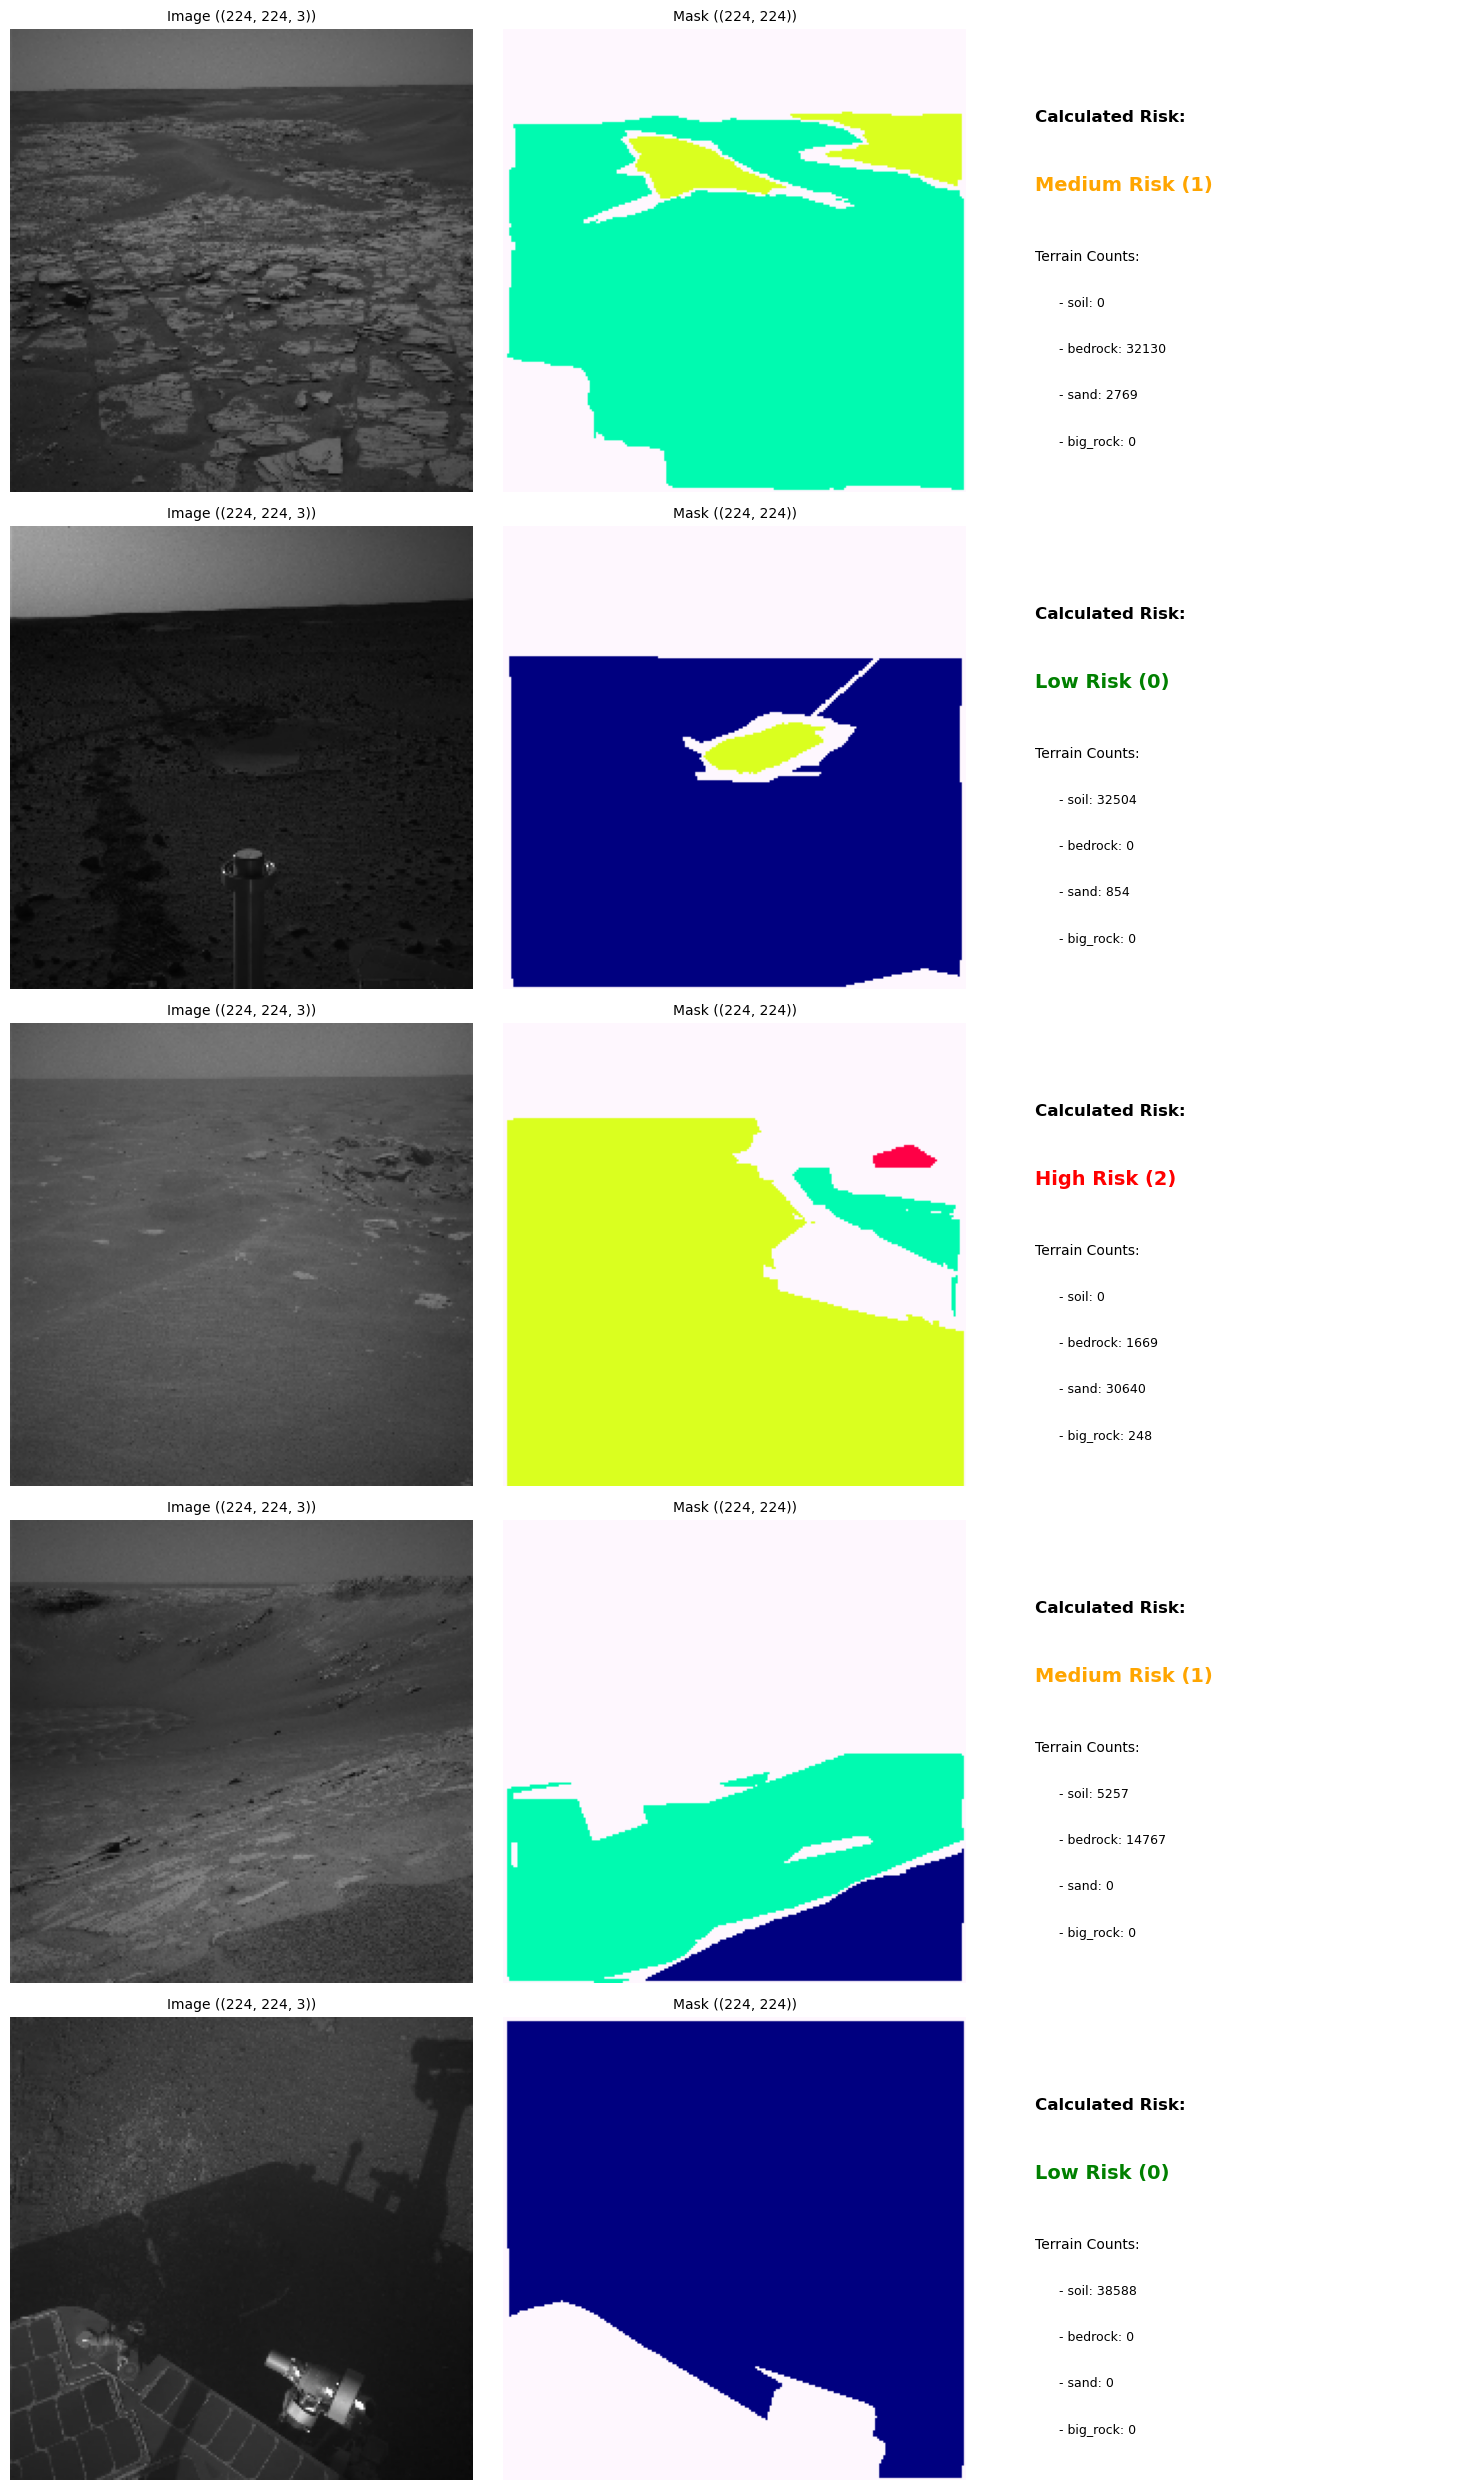

--- Verification Complete ---

--- Running Verification on test data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree
[Matching] Found 204 potential images.
[Matching] Found 204 mask candidates.
[Matching] Successfully identified 204 image/mask pairs.


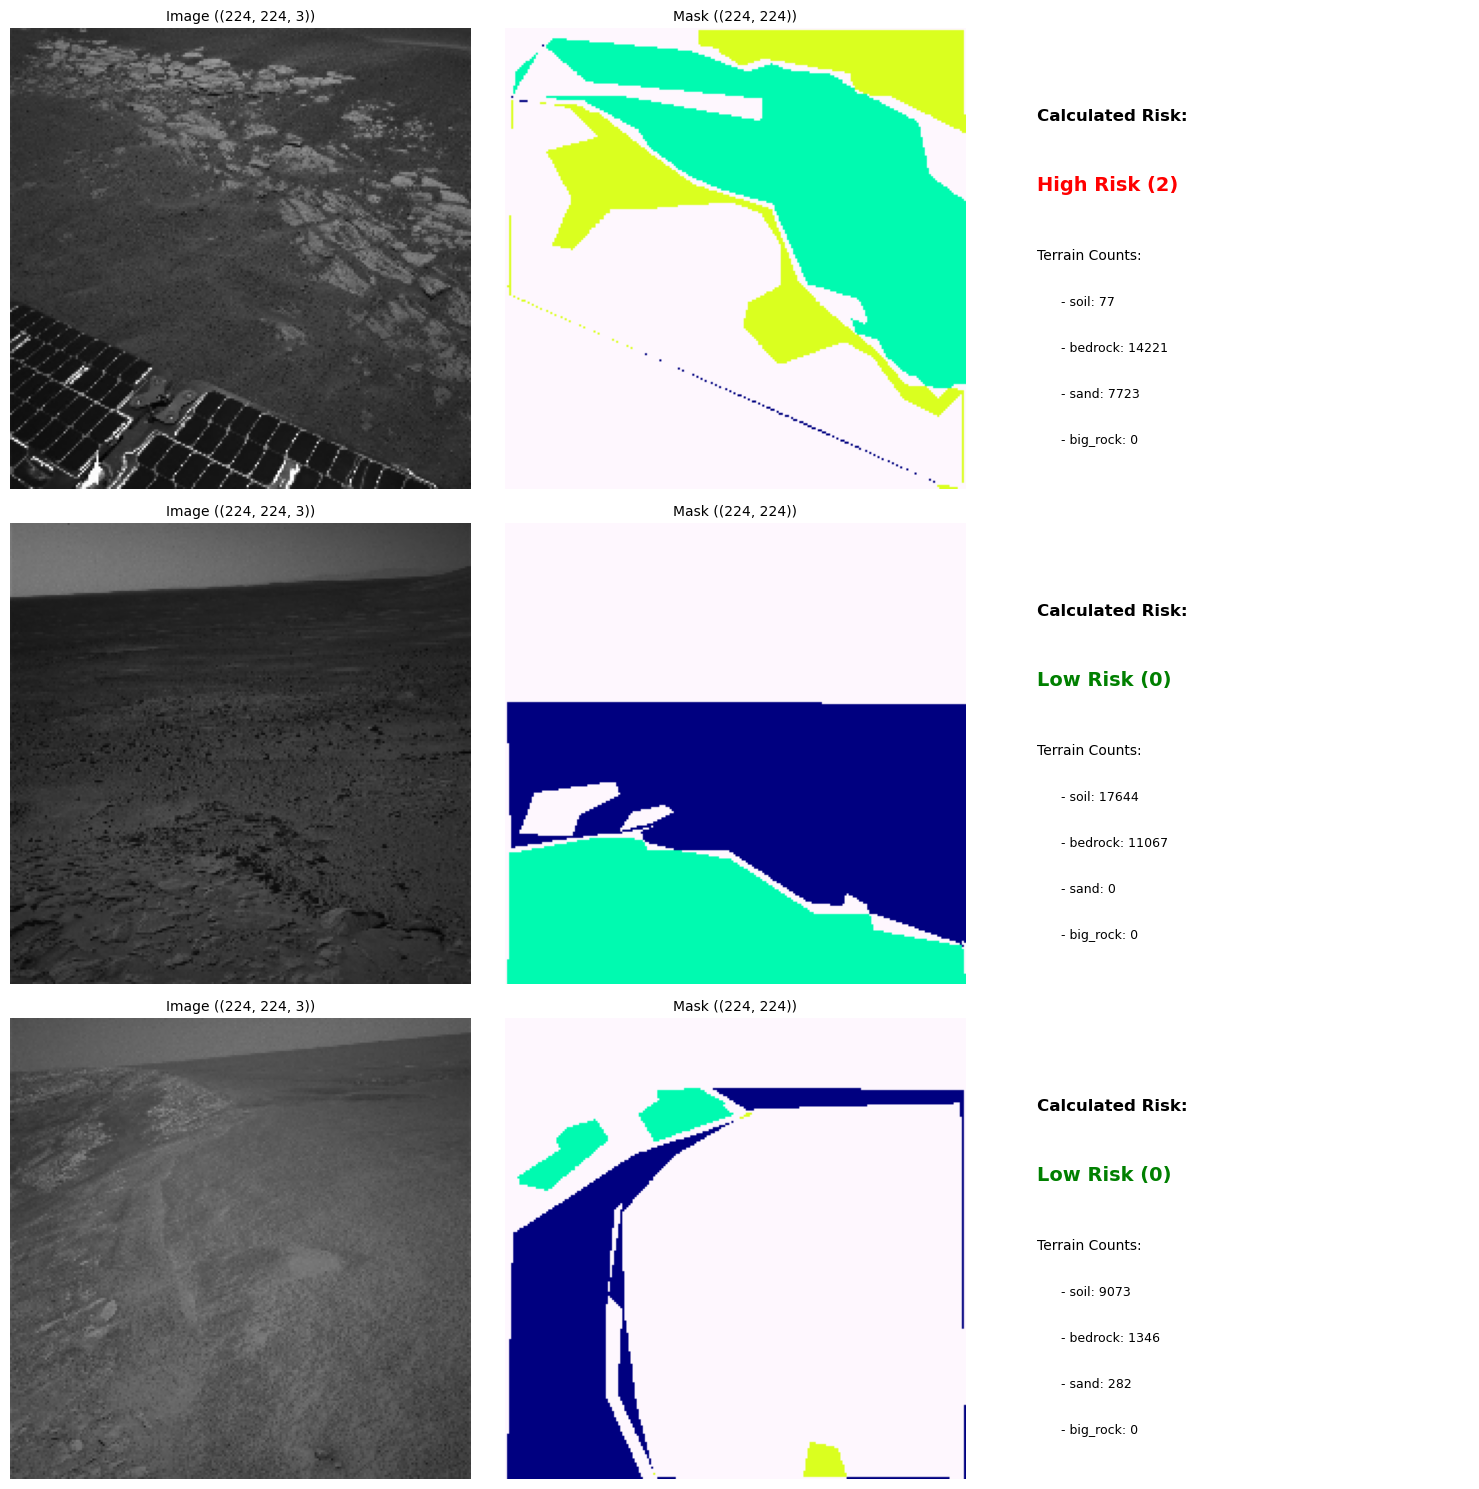

--- Verification Complete ---


In [28]:

# Verify 5 random samples from the Training Data
verify_dataset_sample(mer_train_img_dir, mer_train_mask_dir, num_samples=5)

# Verify 3 random samples from the Independent Test Data
verify_dataset_sample(mer_test_img_dir, mer_test_mask_dir, num_samples=3)